In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from cuml.ensemble import RandomForestRegressor as cuRF
import xgboost as xgb
import optuna

In [4]:
train=pd.read_csv('data/train.csv')

In [5]:
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,432.475954,289.373016,481.315600,358.755566,802.659004,176.761177,72.648102,720.969179,36.327684,83.768878,...,4.385848,516.789458,19.624422,13.162440,42.351948,35.920392,20.755984,13.814300,384.497136,14.364922
1,517.596250,330.448341,585.920055,22.684031,169.813240,335.601640,284.451476,748.101047,73.701438,358.147215,...,5.563334,2.960064,20.721878,17.740184,1.726915,167.576065,75.492679,2.480979,303.710869,19.984801
2,189.439350,553.888820,165.833790,202.465927,176.695586,321.155049,407.278389,161.245668,282.269025,221.570899,...,4.536947,581.823741,101.695639,0.653592,486.859084,117.491548,6.420465,20.713314,22.651537,12.944351
3,237.307878,195.894881,416.752252,468.729031,611.693517,301.411711,241.880655,49.597044,122.396821,13.828319,...,5.518968,45.014729,196.350455,47.638515,411.414213,67.142022,115.630943,8.927957,388.240433,14.792440
4,602.845256,16.103208,221.759979,345.765574,558.588369,276.704241,408.069566,19.390813,138.769765,146.662193,...,2.136214,133.590430,197.634584,26.278027,111.127557,172.181136,85.869642,30.537857,625.931837,11.802634


In [6]:
test=pd.read_csv('data/test.csv')

In [7]:
test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,676.867615,32.518822,254.825875,502.268510,609.469688,497.624266,105.246239,269.045539,150.177005,312.649860,765.296227,0.237996,660.030637,147.059794,40.232132,464.424834,121.147466,68.284243,26.969870,314.461582
1,628.695228,426.163933,347.070280,431.106903,915.527507,301.699534,1.666992,306.733041,104.234252,63.242070,467.009734,6.608084,600.994184,43.619815,48.153926,457.256565,49.163652,85.511662,33.500538,819.537877
2,131.765943,323.839669,245.399775,181.814398,710.179159,59.117377,312.622788,687.965027,109.803179,381.169500,700.532108,1.822370,736.306092,138.759029,36.915389,436.174065,10.037994,62.631938,6.211169,341.361374
3,160.970195,489.712029,70.482159,309.486269,888.030604,412.655666,216.124989,47.415477,104.139145,326.462385,378.446187,1.686895,485.144327,143.668518,27.168148,309.715497,149.661493,66.415878,15.001753,539.087409
4,419.907137,216.625219,487.887860,253.704462,323.226862,65.744463,271.811469,527.726782,129.805782,168.429679,637.944633,0.948507,365.946758,72.337904,36.232169,302.772338,186.944884,106.514846,3.443809,364.341969


## EDA
We need to do some EDA with two main objectives:
- understand the distribution (and differences in distribution) of train and test features
- see if there are non random patterns between features and target and start creating mental models of their predictive power.

In [8]:
features=train.columns.difference(['target'])

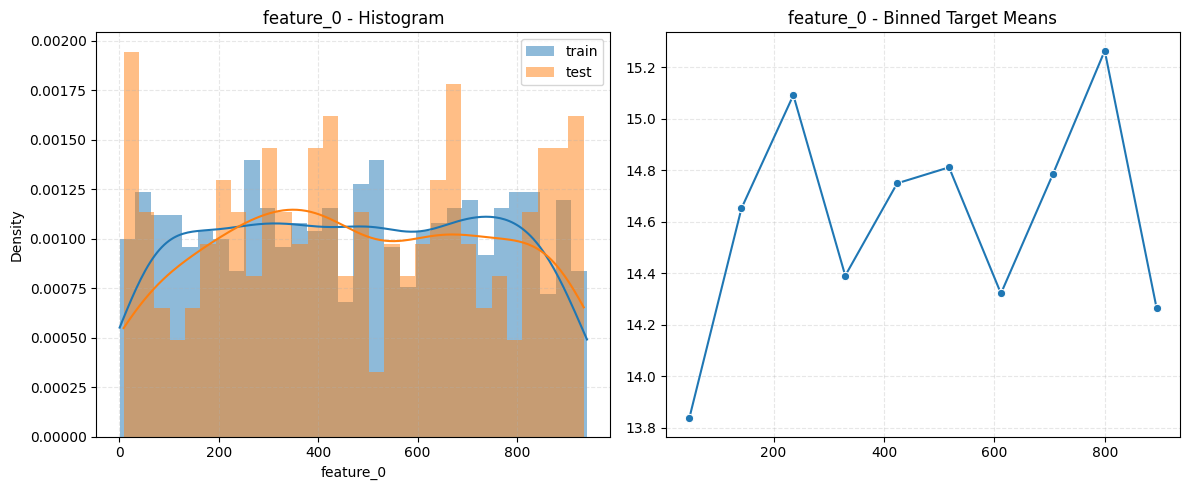

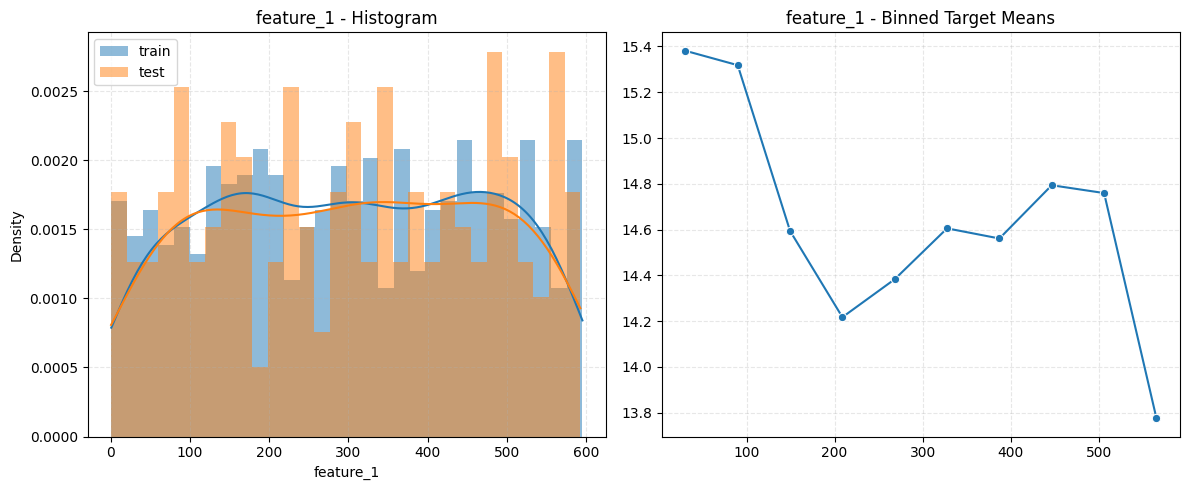

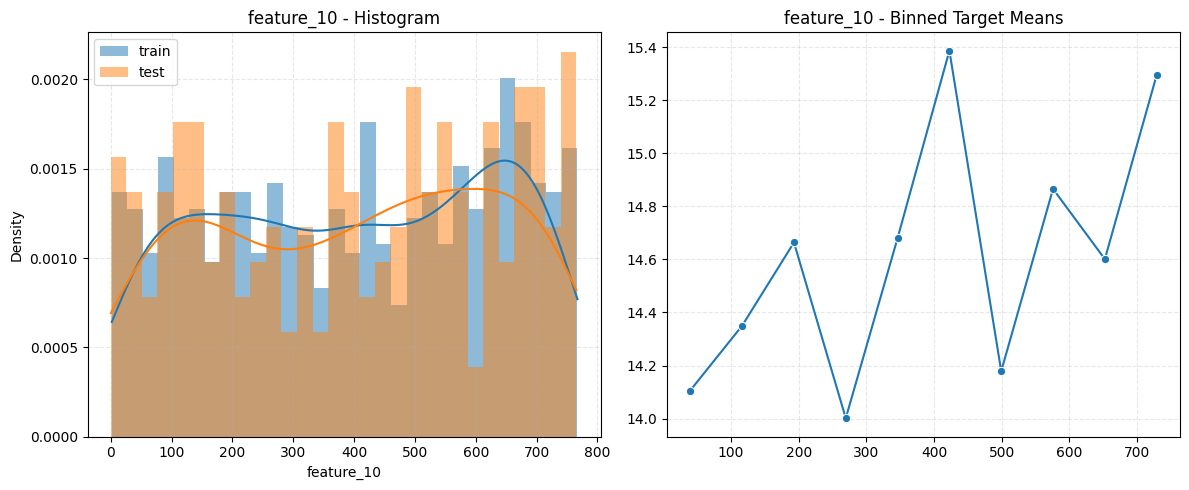

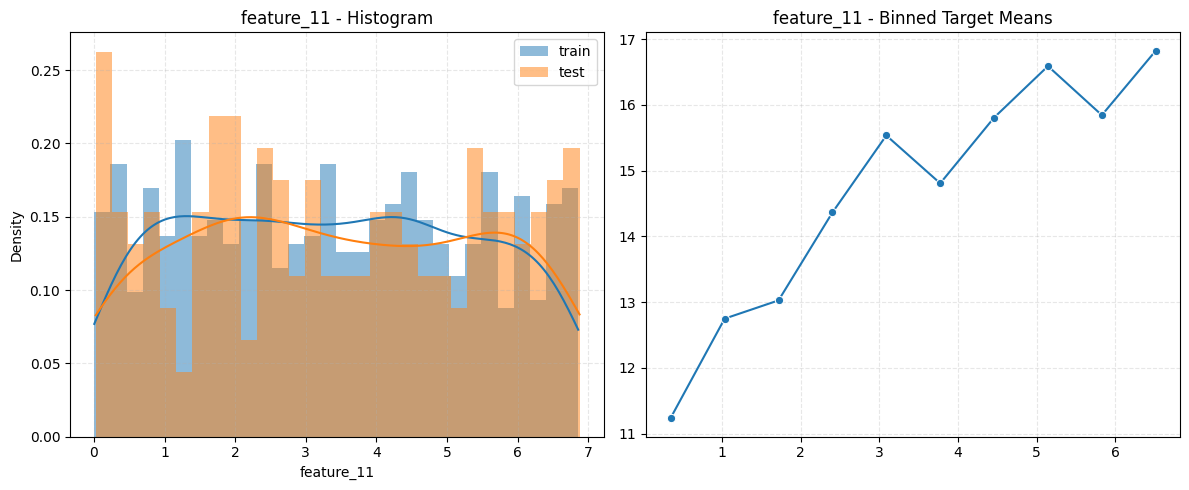

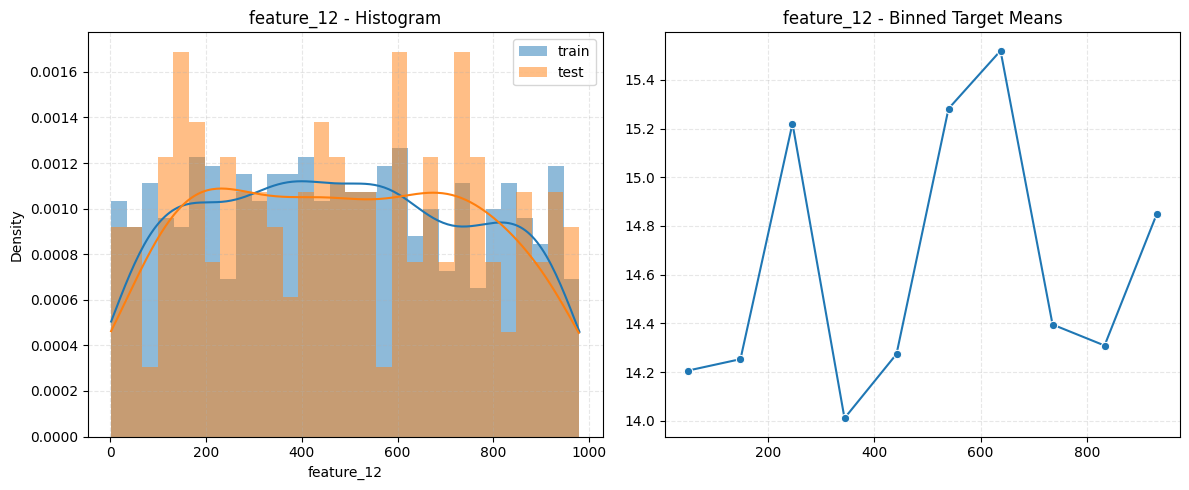

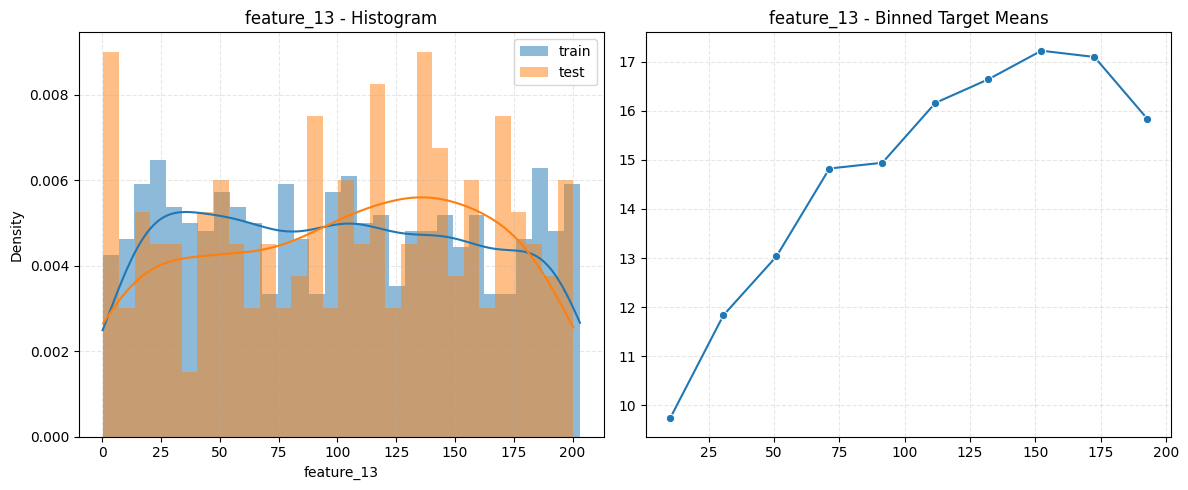

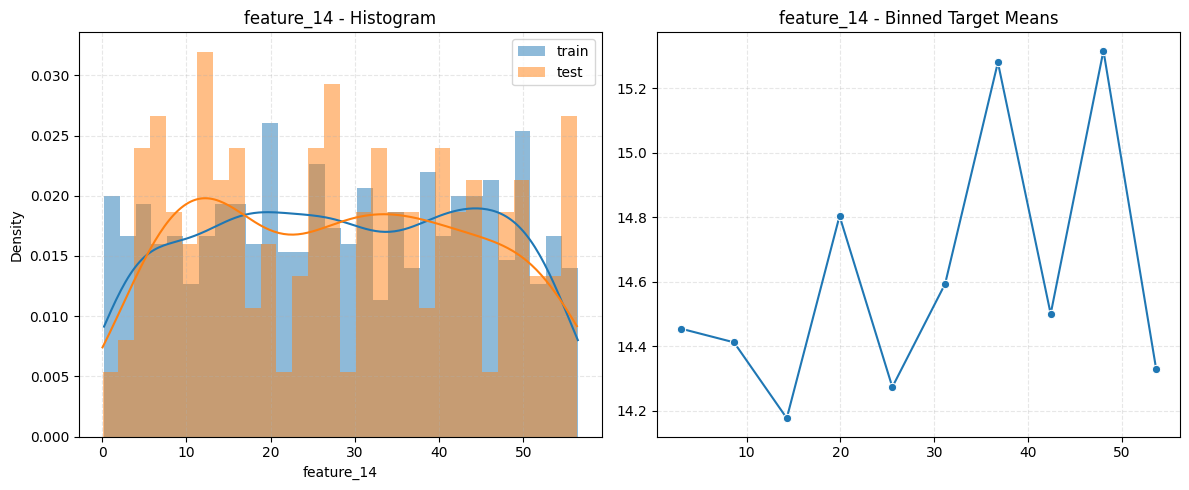

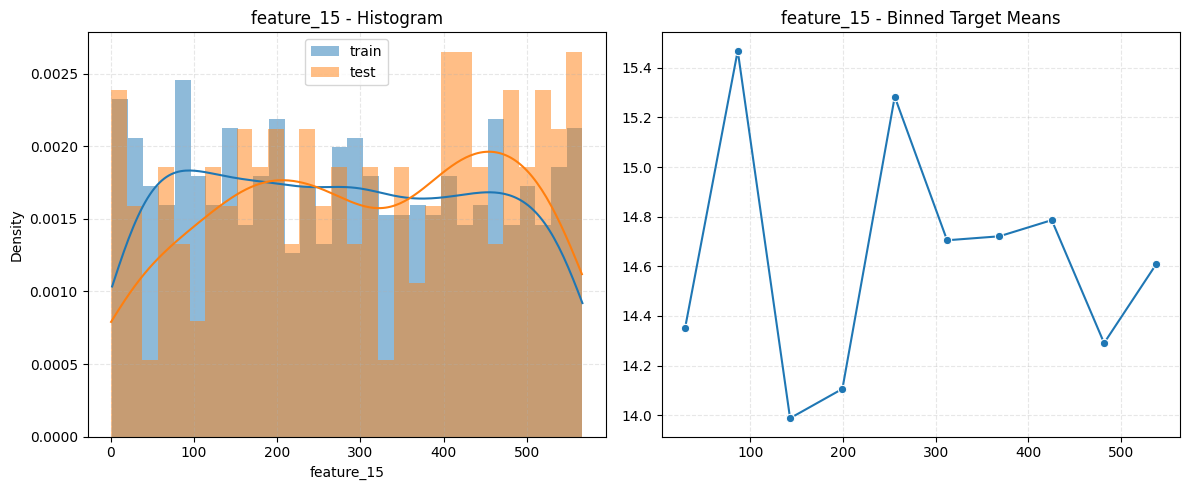

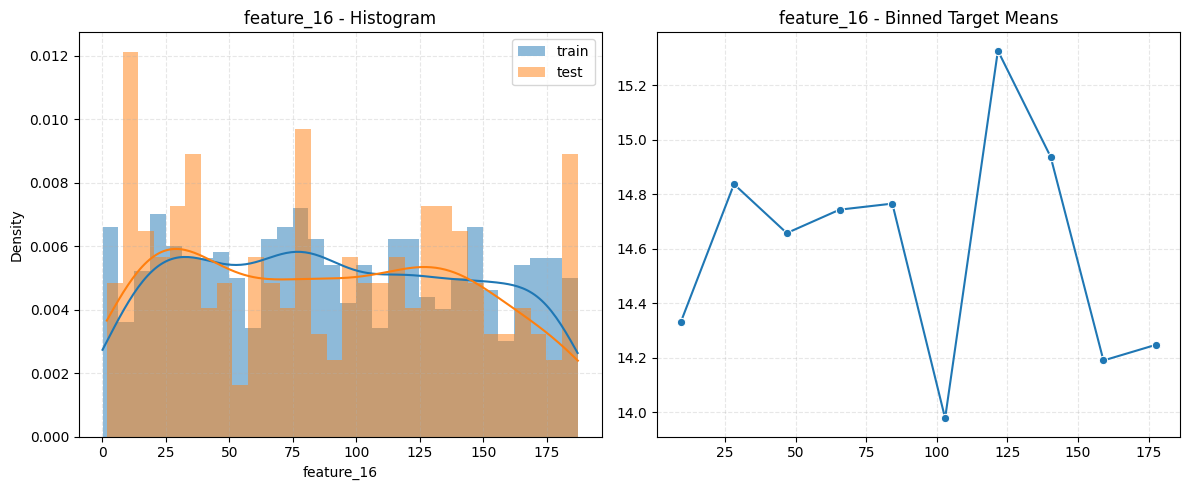

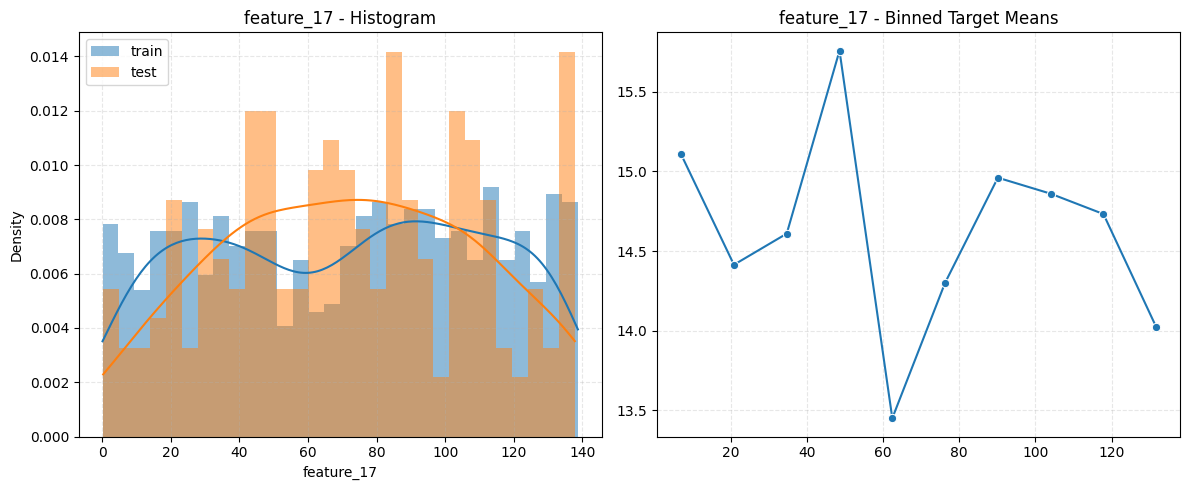

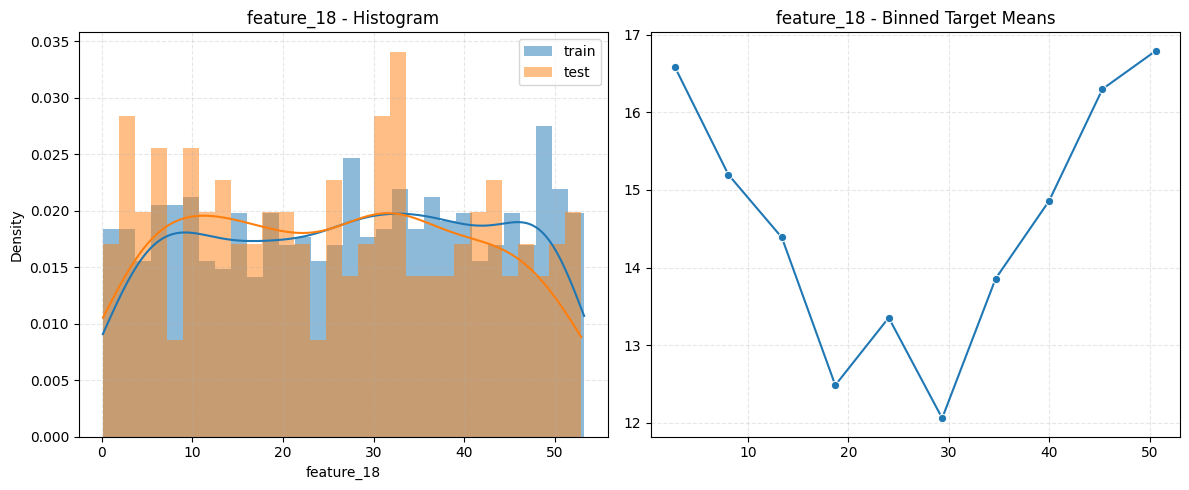

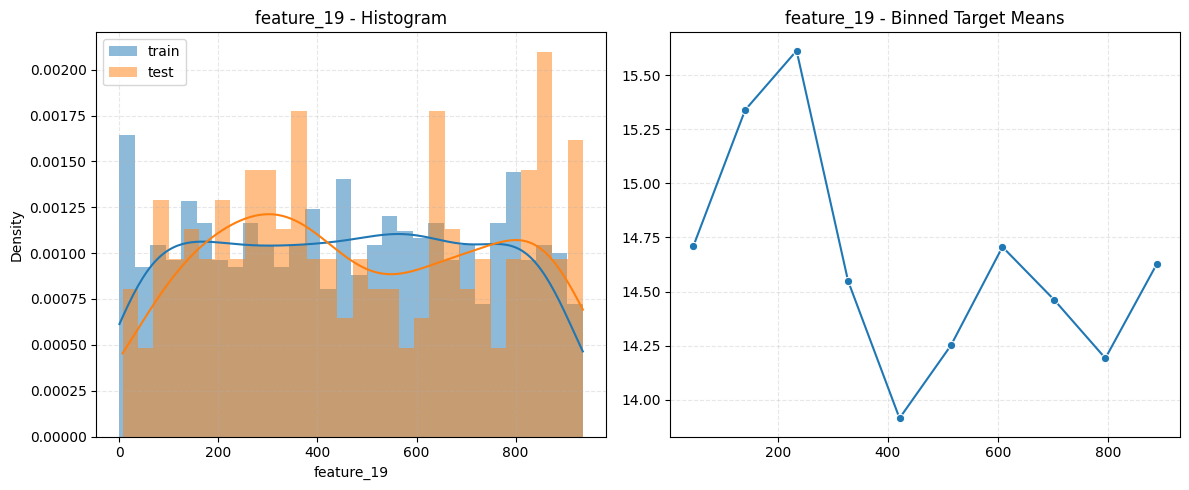

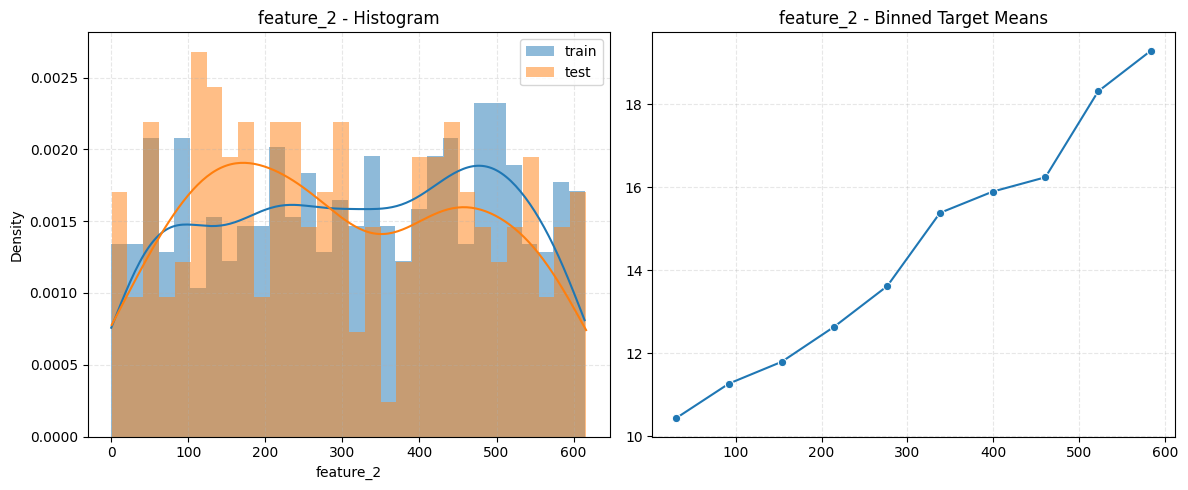

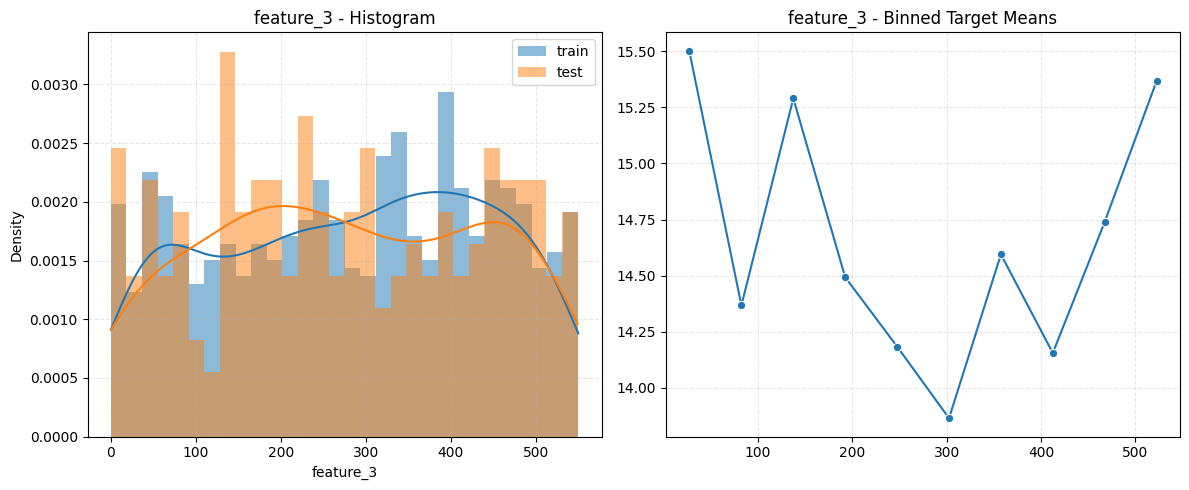

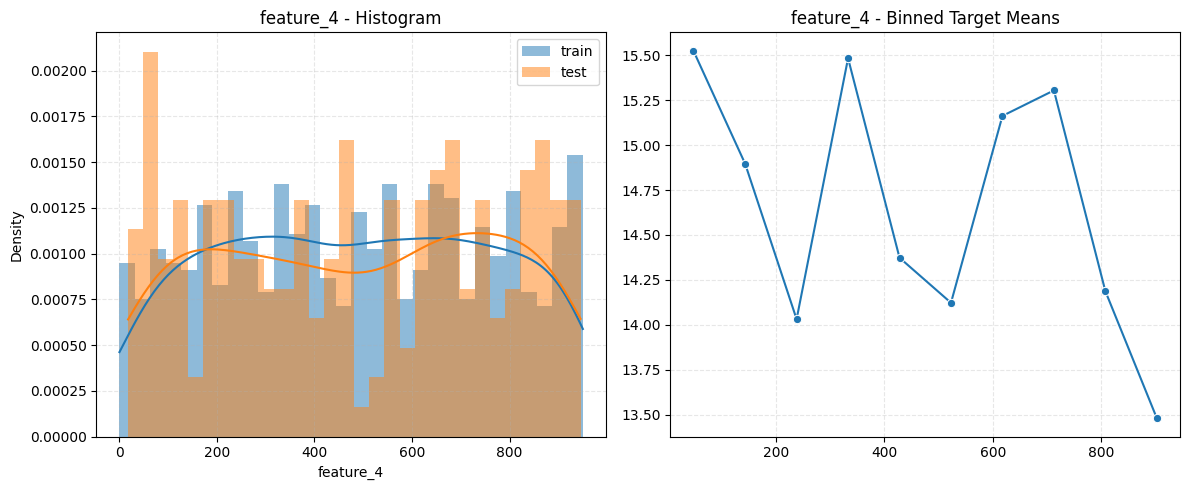

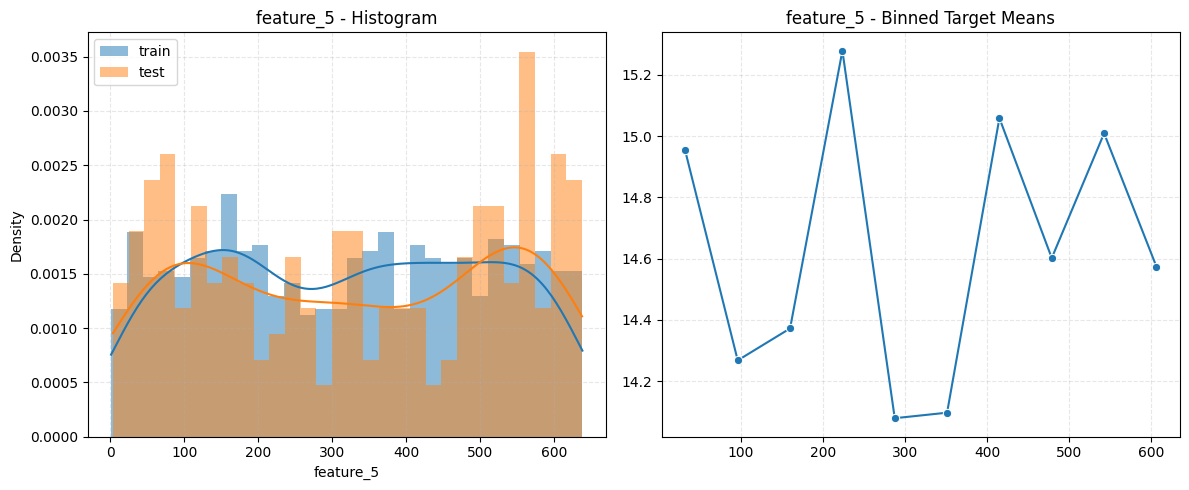

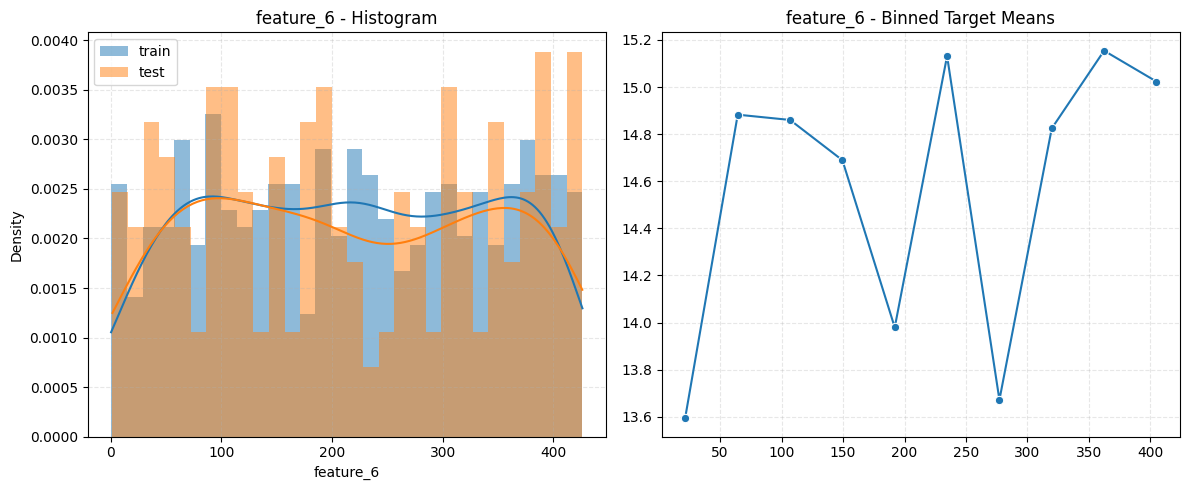

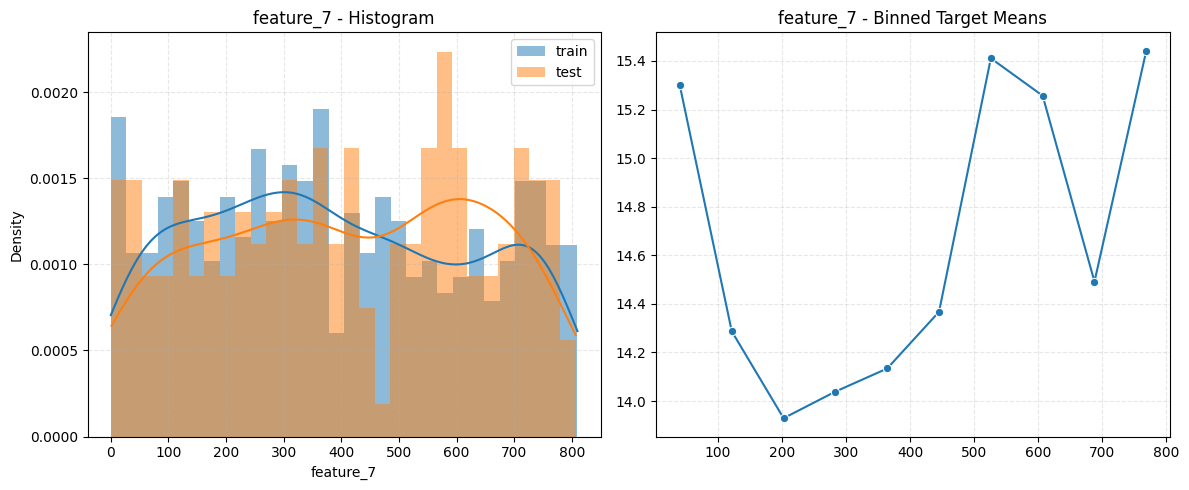

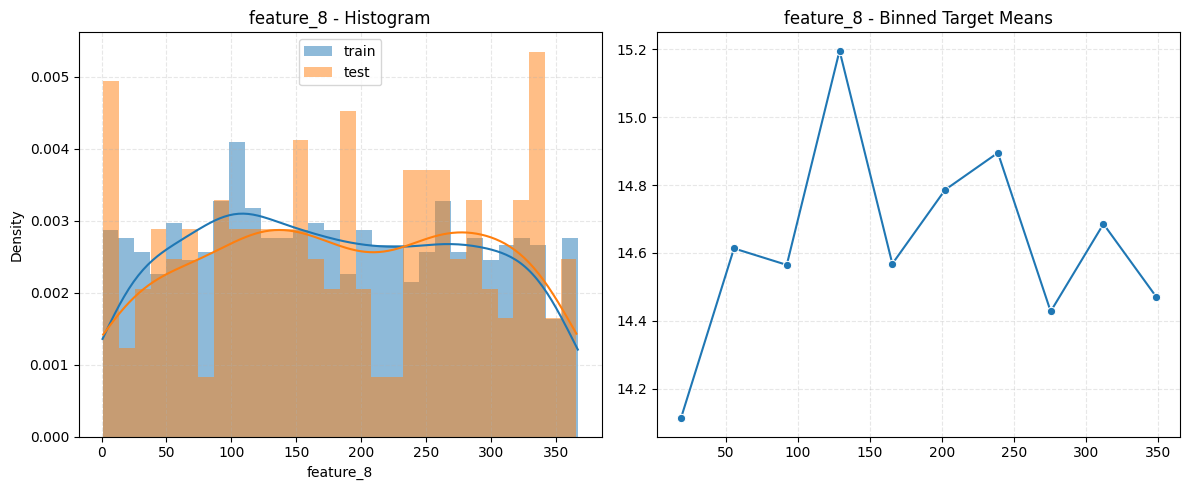

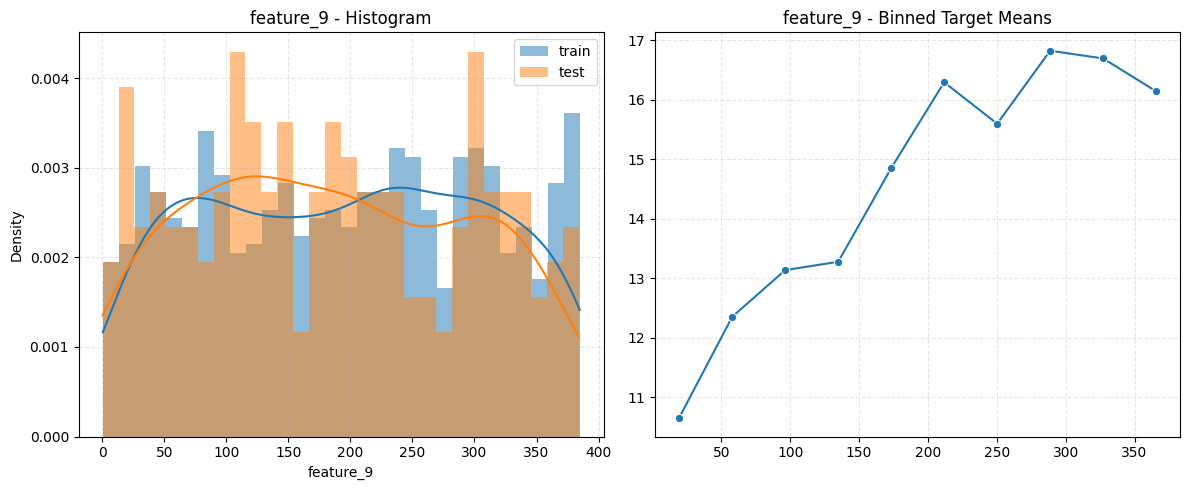

In [9]:
for feature in features:
    plt.figure(figsize=(12, 5))

    # Left subplot: histogram for train and test
    plt.subplot(1, 2, 1)

    sns.histplot(train[feature], stat='density', label='train',  bins=30,  alpha=0.5, edgecolor = None, kde=True)
    sns.histplot(test[feature], stat='density', label='test',  bins=30, alpha=0.5, edgecolor = None, kde=True)
    plt.legend()
    plt.title(f"{feature} - Histogram")
    plt.grid(True, linestyle='--', alpha=0.3)


    # Right subplot: binned target means
    plt.subplot(1, 2, 2)
    cat, bin_edges = pd.cut(train[feature], bins=10, retbins=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    means = train['target'].groupby(cat, observed=False).mean()
    sns.lineplot(x=bin_centers, y=means.values, marker='o')
    plt.title(f"{feature} - Binned Target Means")
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

- The distributions look very flat, we should not use models that assume normality.
- I am worried about differences in distribution between test and train for some features, particularly feature_5, feature_3, feature_7. We can transform the data or bin it to better match the distributions or we can just add good regularization to reduce the variance of the model and make it depend less on particular features. Relevant parameters that come into mind are feature sample for tree based models, and L2 regularization for linear models.
- Some features have very clear relationships with the target, e.g. feature_9, feature_7, feature_2, feature_18, feature_13, feature_11 and feature_1.
- Log transforms don't seem to be relevant here.
- There are non-linear relationships.
- None of the features is categorical so no mean encodings are relevant here.
- No clear grouping for kfold or order in the data disclosed.

In [10]:
train.isnull().apply(sum) #Check for nulls

,0
feature_0,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0
feature_9,0


In [11]:
test.isnull().apply(sum) #Check for nulls

,0
feature_0,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0
feature_9,0


# Strategy:
- Use cross validation for model selection
- Use Gradient Boosting, Random Forest and TabPFN
- Gradually add features (interactions, difference, ratios) and remove them if they don't add value
- Run optuna experiments for hyperparameter tunning.

In [13]:
BASELINE=train.columns.difference(['target']).tolist()

In [14]:
# Generate interaction features
INTERACT = []
for i, c1 in enumerate(BASELINE):
    for j, c2 in enumerate(BASELINE[i+1:]):
        # Multiply
        n1 = f"{c1}_x_{c2}"
        train[n1] = train[c1] * train[c2]
        test[n1] = test[c1] * test[c2]
        INTERACT.append(n1)

        # Ratio
        n2 = f"{c1}_div_{c2}"
        train[n2] = train[c1] / (train[c2] + 1e-6)
        test[n2] = test[c1] / (test[c2] + 1e-6)
        INTERACT.append(n2)

        # Difference
        n3 = f"{c1}_sub_{c2}"
        train[n3] = train[c1] - train[c2]
        test[n3] = test[c1] - test[c2]
        INTERACT.append(n3)

print(f"There are {len(INTERACT)} interaction features:")

# Create interaction feature DataFrames
df_inter = train[INTERACT].copy()
df_inter_test = test[INTERACT].copy()

<ipython-input-14-40b49dda53e2>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[n1] = train[c1] * train[c2]
<ipython-input-14-40b49dda53e2>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[n1] = test[c1] * test[c2]
<ipython-input-14-40b49dda53e2>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

There are 570 interaction features:


<ipython-input-14-40b49dda53e2>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[n1] = test[c1] * test[c2]
<ipython-input-14-40b49dda53e2>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[n2] = train[c1] / (train[c2] + 1e-6)
<ipython-input-14-40b49dda53e2>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
ADD = []
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

best_pooled_rmse = float('inf')

for j in ['baseline'] + INTERACT:
    test_pred = np.zeros(test.shape[0])
    val_pred = np.full(train.shape[0], np.nan)
    train_rmse_list = []

    if j != 'baseline':
        ADD.append(j)

    for i, (train_index, val_index) in enumerate(kf.split(train)):
        X_train = pd.concat([train, df_inter], axis=1).loc[train_index, BASELINE + ADD].copy()
        X_val = pd.concat([train, df_inter], axis=1).loc[val_index, BASELINE + ADD].copy()
        y_train = train.loc[train_index, 'target']
        y_val = train.loc[val_index, 'target']
        X_test = pd.concat([test, df_inter_test], axis=1).loc[:, BASELINE + ADD]

        model = cuRF(
            n_estimators=100,
            random_state=99,
            n_streams=4,
            max_features=0.9,
            max_samples=0.9,
            max_depth=5
        )
        model.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        val_pred[val_index] = val_preds
        test_pred += model.predict(X_test)

        rmse_train = root_mean_squared_error(y_train, train_preds)
        train_rmse_list.append(rmse_train)

    test_pred /= N_FOLDS

    # Compute final metrics after folds
    avg_train_rmse = np.mean(train_rmse_list)
    pooled_val_rmse = root_mean_squared_error(train['target'], val_pred)

    print(f'✅ Avg Train RMSE: {avg_train_rmse:.4f}')
    print(f'✅ Pooled Val RMSE: {pooled_val_rmse:.4f}')

    if pooled_val_rmse < best_pooled_rmse:
        best_pooled_rmse = pooled_val_rmse
        best_pred = test_pred.copy()
    else:
        ADD.remove(j)

    print(f'🏁 Current best RMSE: {best_pooled_rmse:.4f}')

print(f'\n🎯 Best pooled RMSE: {best_pooled_rmse:.4f}')
print(f'📌 Selected interaction features: {ADD}')

✅ Avg Train RMSE: 2.0821
✅ Pooled Val RMSE: 2.7200
🏁 Current best RMSE: 2.7200
✅ Avg Train RMSE: 2.0566
✅ Pooled Val RMSE: 2.6863
🏁 Current best RMSE: 2.6863
✅ Avg Train RMSE: 2.0544
✅ Pooled Val RMSE: 2.6882
🏁 Current best RMSE: 2.6863
✅ Avg Train RMSE: 2.0547
✅ Pooled Val RMSE: 2.6881
🏁 Current best RMSE: 2.6863
✅ Avg Train RMSE: 2.0540
✅ Pooled Val RMSE: 2.6891
🏁 Current best RMSE: 2.6863
✅ Avg Train RMSE: 2.0548
✅ Pooled Val RMSE: 2.6856
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0572
✅ Pooled Val RMSE: 2.6892
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0556
✅ Pooled Val RMSE: 2.6880
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0561
✅ Pooled Val RMSE: 2.6960
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0568
✅ Pooled Val RMSE: 2.6893
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0575
✅ Pooled Val RMSE: 2.6892
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0578
✅ Pooled Val RMSE: 2.6865
🏁 Current best RMSE: 2.6856
✅ Avg Train RMSE: 2.0580
✅ Pooled Val RMSE: 2.6871
🏁

In [22]:
ADD # fetures to add to final model.

['feature_0_x_feature_1',
 'feature_0_div_feature_10',
 'feature_0_div_feature_15',
 'feature_11_x_feature_13',
 'feature_11_sub_feature_18',
 'feature_11_sub_feature_19',
 'feature_11_x_feature_2',
 'feature_13_x_feature_2',
 'feature_13_x_feature_9',
 'feature_13_div_feature_9',
 'feature_13_sub_feature_9',
 'feature_18_div_feature_2',
 'feature_18_sub_feature_2']

In [57]:
best_pooled_rmse

2.274283169668453

<Axes: >

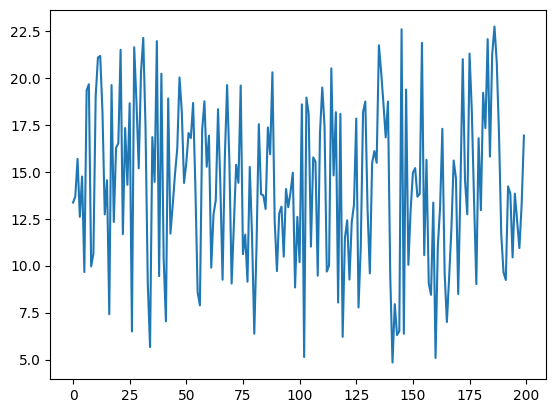

In [25]:
best_pred.plot()

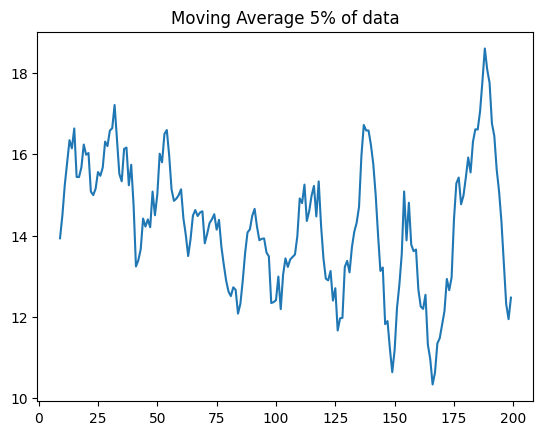

In [46]:
best_pred.rolling(10).mean().plot()
plt.title('Moving Average 5% of data') #just to see if there is any order or clear seasonal/ time series obvious patterns.
plt.show()

Let's try xgboost with the selected features

In [50]:

!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [64]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

X = train[BASELINE + ADD]
y = train['target']
X_test = test[BASELINE + ADD]

val_preds = np.full(X.shape[0], np.nan)
test_preds = np.zeros(X_test.shape[0])
train_rmse_list = []

for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'max_depth': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'learning_rate': 0.05,
        'seed': 99
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    val_preds[val_idx] = model.predict(dval)
    test_preds += model.predict(dtest) / N_FOLDS
    train_rmse = root_mean_squared_error(y_train, model.predict(dtrain))
    train_rmse_list.append(train_rmse)

# Final metrics
pooled_rmse = root_mean_squared_error(y, val_preds)
print(f"✅ XGBoost pooled RMSE: {pooled_rmse:.4f}")
print(f"✅ Avg train RMSE across folds: {np.mean(train_rmse_list):.4f}")

✅ XGBoost pooled RMSE: 1.7416
✅ Avg train RMSE across folds: 0.7569


Already doing much better than random forest, even though it's overfitting a bit. Let's use this model and run optuna trials.

In [74]:

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.2 MB/s eta 0:00:00


In [75]:



N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

X = train[BASELINE + ADD]
y = train['target']
X_test = test[BASELINE + ADD]

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'seed': 99
    }

    val_preds = np.full(X.shape[0], np.nan)
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        val_preds[val_idx] = model.predict(dval)

    pooled_rmse = root_mean_squared_error(y, val_preds)
    return pooled_rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"✅ Best RMSE: {study.best_value:.4f}")
print("✅ Best hyperparameters:")
print(study.best_params)


[I 2025-04-09 01:16:06,238] A new study created in memory with name: no-name-7f6d5db1-5ade-4b52-86bb-d383a9139f3a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-09 01:16:09,722] Trial 0 finished with value: 2.0782886652641293 and parameters: {'max_depth': 9, 'learning_rate': 0.1444507832439117, 'subsample': 0.6129907030795665, 'colsample_bytree': 0.8172874180756591, 'reg_alpha': 2.187529984520933}. Best is trial 0 with value: 2.0782886652641293.
[I 2025-04-09 01:16:11,072] Trial 1 finished with value: 1.7563849590107847 and parameters: {'max_depth': 3, 'learning_rate': 0.11737495182422142, 'subsample': 0.5280139799024715, 'colsample_bytree': 0.5948375358710095, 'reg_alpha': 4.307026830992166}. Best is trial 1 with value: 1.7563849590107847.
[I 2025-04-09 01:16:13,791] Trial 2 finished with value: 2.1754936815755936 and parameters: {'max_depth': 10, 'learning_rate': 0.17164723919865943, 'subsample': 0.7150887378091962, 'colsample_bytree': 0.9448684782851531, 'reg_alpha': 2.829189520549833}. Best is trial 1 with value: 1.7563849590107847.
[I 2025-04-09 01:16:16,263] Trial 3 finished with value: 1.7708101390906104 and parameters: {'max

In [76]:
train.target.describe()

,target
count,800.000000
mean,14.631342
std,5.089503
min,0.279805
25%,10.879914
50%,14.687955
75%,18.224713
max,27.360789


Given that the target has a 5.08 std, the model is doing very good with 1.68 rmse.

In [77]:

# Prepare full dataset
X_train = train[BASELINE + ADD]
y_train = train['target']
X_test = test[BASELINE + ADD]  # optional, if you want test predictions

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Use best params from Optuna
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'seed': 99
})

# Train final model
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000
)


In [109]:
importance_df

,feature,importance
27,feature_13_x_feature_2,202.834152
28,feature_13_x_feature_9,199.061356
26,feature_11_x_feature_2,149.090897
12,feature_2,144.581116
32,feature_18_sub_feature_2,113.173569
19,feature_9,61.570461
24,feature_11_sub_feature_18,49.835693
23,feature_11_x_feature_13,46.596756
31,feature_18_div_feature_2,44.118584
10,feature_18,41.425674


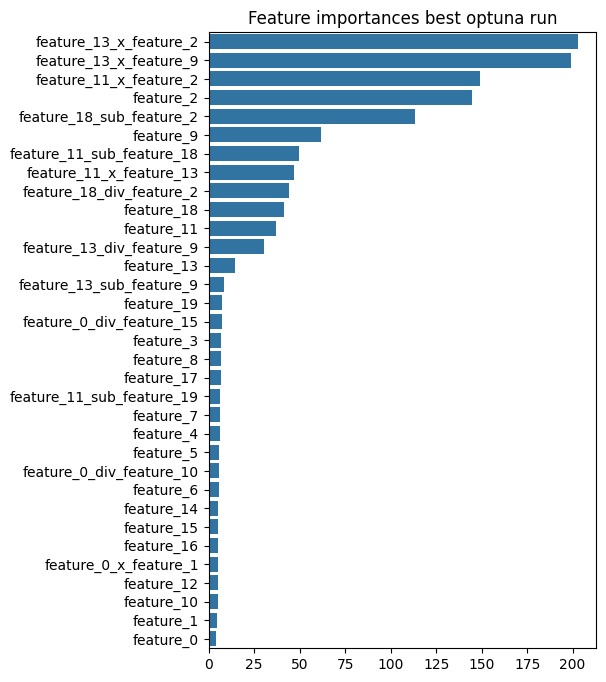

In [120]:
importance_dict = final_model.get_score(importance_type='gain')
importance=pd.Series(importance_dict)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(5,8))
sns.barplot(importance, orient='y')
plt.title('Feature importances best optuna run')
plt.show()

Some features could potentially be removed if we need lower latency (and better maintainability), the metric won't be hurt so much.

In [83]:
pd.Series(final_model.predict(xgb.DMatrix(test[BASELINE + ADD]))).to_csv('test_preds.csv', index=False)

In [78]:
import pickle

with open("xgboost_optuna_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
